In [46]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [47]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from sklearn.model_selection import train_test_split, cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Метрики для классификации
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Misc
from sklearn.manifold import TSNE

# Для проверки, что один из параметров нормальный
from scipy import stats

# Для того, чтобы узнать возраст игрока
from datetime import datetime as dt

Используем датасет NBA

In [48]:
df = pd.read_csv('./nba2k20-full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   full_name    429 non-null    object
 1   rating       429 non-null    int64 
 2   jersey       429 non-null    object
 3   team         406 non-null    object
 4   position     429 non-null    object
 5   b_day        429 non-null    object
 6   height       429 non-null    object
 7   weight       429 non-null    object
 8   salary       429 non-null    object
 9   country      429 non-null    object
 10  draft_year   429 non-null    int64 
 11  draft_round  429 non-null    object
 12  draft_peak   429 non-null    object
 13  college      363 non-null    object
dtypes: int64(2), object(12)
memory usage: 47.0+ KB


In [49]:
# распределение рейтинга на категории

def category_by_rating(rating):
    # 67 to 97
    if rating > 91:
        return 1
    elif rating > 85:
        return 2
    elif rating > 79:
        return 3
    elif rating > 73:
        return 4
    else:
        return 5

# вычисление возроста
start_day = dt.strptime('01/01/21', '%d/%m/%y')
def age_by_bdate(bdate):
    date = dt.strptime(bdate, '%m/%d/%y')
    dif = start_day - date
    return int(dif.days / 365.2425)

df.replace('', np.nan, inplace=True)
df.dropna()
df.head()

new_df = pd.DataFrame()
new_df['height'] = df['height'].map(lambda s: s.split('/')[1][1:]).astype(float)
new_df['age'] = df['b_day'].apply(age_by_bdate)
new_df['salary'] = df['salary'].apply(lambda s: int(s[1:]))
new_df['rating_category'] = df['rating'].apply(category_by_rating)
new_df.head()

,height,age,salary,rating_category
0,2.06,36,37436858,1
1,2.01,29,32742000,1
2,2.11,26,25842697,1
3,2.08,32,37199000,1
4,1.96,31,38199000,1


In [50]:
print(stats.normaltest(new_df['height']))
print(stats.normaltest(new_df['age']))
print(stats.normaltest(new_df['salary']))

NormaltestResult(statistic=4.846177468074185, pvalue=0.08864738596500196)
NormaltestResult(statistic=18.6758233868369, pvalue=8.802306342770477e-05)
NormaltestResult(statistic=112.96035398868945, pvalue=2.9578135519485964e-25)


Рост - нормальная величина

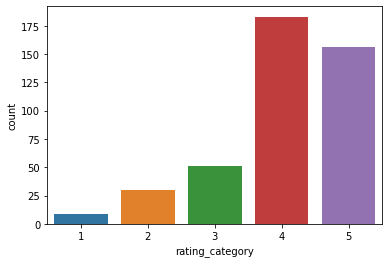

In [51]:
sns.countplot(x='rating_category', data=new_df);

In [52]:
X = new_df[['salary','age','height']]
y = new_df['rating_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2)

knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

for clf in [knn_clf, svm_clf, forest_clf]: 
    clf.fit(X_train, y_train)

knn_pred = knn_clf.predict(X_test)
svm_pred = svm_clf.predict(X_test)
forest_pred = forest_clf.predict(X_test)

knn_acc_score = balanced_accuracy_score(y_test, knn_pred)
svm_acc_score = balanced_accuracy_score(y_test, svm_pred)
forest_acc_score = balanced_accuracy_score(y_test, forest_pred)

leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. KNN: 0.47811682650392323
2. SVC: 0.45015983725661146
3. Forest: 0.4066608544027899


In [53]:
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Посчитаем метрику качества используя кросс-валидацию
knn_acc_score = cross_val_score(knn_clf, X, y, cv=7, scoring='balanced_accuracy').mean()
svm_acc_score = cross_val_score(svm_clf, X, y, cv=7, scoring='balanced_accuracy').mean()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7, scoring='balanced_accuracy').mean()

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. KNN: 0.46984152263655377
2. SVC: 0.4430059312668009
3. Forest: 0.41941249341870457
